In [80]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf

In [183]:
#DESCARGA DE DATOS
data = pd.read_excel('Generación Intermitente de la GCROC 2013-2019.xlsx', header=1)
data2 = pd.read_excel('plantas_intermitentes_clean.xlsx', header=1)
data2.head()

,Unnamed: 0,dia_semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,...,GICIS308,GICIS309,GICIS310,GICIS311,GICIS312,GICIS313,GICIS314,GICIS315,GICIS316,fecha_hora
0,1,jueves,2013-11-14,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 01:00:00
1,2,jueves,2013-11-14,2,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 02:00:00
2,3,jueves,2013-11-14,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 03:00:00
3,4,jueves,2013-11-14,4,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 04:00:00
4,5,jueves,2013-11-14,5,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 05:00:00


In [157]:
data['fecha']= data['fecha'].fillna(method='ffill')

In [187]:
data2 = data2.set_index(data2['fecha_hora'])

([<matplotlib.axis.XTick at 0x1c4cba3c90>,
 <a list of 4 Text xticklabel objects>)

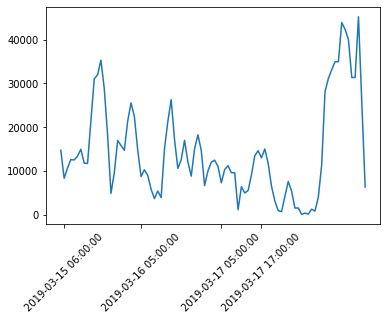

In [198]:
plt.plot(data2['GICIE301'][-92:]);
plt.xticks([1,24,48,60],rotation=45);

In [191]:
help(plt.xticks)

Help on function xticks in module matplotlib.pyplot:

xticks(ticks=None, labels=None, **kwargs)
    Get or set the current tick locations and labels of the x-axis.
    
    Call signatures::
    
        locs, labels = xticks()            # Get locations and labels
        xticks(ticks, [labels], **kwargs)  # Set locations and labels
    
    Parameters
    ----------
    ticks : array_like
        A list of positions at which ticks should be placed. You can pass an
        empty list to disable xticks.
    
    labels : array_like, optional
        A list of explicit labels to place at the given *locs*.
    
    **kwargs
        :class:`.Text` properties can be used to control the appearance of
        the labels.
    
    Returns
    -------
    locs
        An array of label locations.
    labels
        A list of `.Text` objects.
    
    Notes
    -----
    Calling this function with no arguments (e.g. ``xticks()``) is the pyplot
    equivalent of calling `~.Axes.get_xticks` and `

In [151]:
#LIMPIEZA DE DATOS
#Se elimina el primer día (14-11-2013) ya que muchas horas no tienen registro.
data = data.reset_index(level=None)
data = data.drop(range(0, 24),axis=0)
#data = data.set_index(data['fecha'])

In [152]:
columns = ['GICIE301','GICIE302', 'GICIE303', 'GICIE304', 'GICIE305', 'GICIS306', 'GICIS307','GICIS308', 
           'GICIS309', 'GICIS310', 'GICIS311', 'GICIS312', 'GICIS313','GICIS314', 'GICIS315', 'GICIS316']

In [153]:
def mape(forecast, actual):
    return np.mean(np.abs((forecast - actual)/actual))  # MAPE

In [154]:
def AIC_accuracy(train,test):
    fcc = []
    for i in range(1,25):
        data = train['Hora '+str(i)].dropna()
        model = pm.auto_arima(data.values, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=4, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        model.fit(data.values)
        #print(model)
        #model.plot_diagnostics(figsize=(7,5))
        #plt.show()
        # Predicción
        fc, confint = model.predict(n_periods=len(test), return_conf_int=True)
        fcc.append(fc)
    return(fcc, model)

In [155]:
def mape_prom(columna):
    data2 = data[['hora',columna]]
    data2[columna] = (data[columna]+1) # para efectos de las tranformaciones logaritmicas(eliminar el 0)
    data2 = data2.dropna()
    # se separara por hora del día, ya que cada hora se comporta diferente
    xhr = pd.DataFrame() ; log = pd.DataFrame() ; rends = pd.DataFrame() ; rlogs = pd.DataFrame()
    ano,dia,hora= str(data2.index[1])[0:4], str(data2.index[1])[5:7] ,str(data2.index[1])[8:10]
    for i in range(1,25):
        hrs = [data2.iloc[j][1] for j in range(len(data2)) if data2.iloc[j][0] == i ] #pd.Series()
        xhr['Hora '+str(i)] = hrs
        log['Hora '+str(i)] = [ np.log(hrs[j]) for j in range(len(hrs))]
    xhr = xhr.set_index(pd.date_range(pd.datetime(int(ano),int(dia),int(hora)),periods=len(data2)/24))
    log = log.set_index(pd.date_range(pd.datetime(int(ano),int(dia),int(hora)),periods=len(data2)/24))
    #MODELO ARIMA
    test = (xhr.iloc[-5:,:])-1   # INFO DE TEST
    date_list = [datetime(2019, 3, 14),
             datetime(2019, 3, 15),
             datetime(2019, 3, 16),
             datetime(2019, 3, 17),
             datetime(2019, 3, 18)]
    train = log.drop(date_list) # QUITANDO TEST PARA TRAIN
    fc, model = AIC_accuracy(train,test)
    mapes = [mape(fc[i-1], np.log(test['Hora '+str(i)])) for i in range(1,25)]
    mapes = pd.DataFrame(mapes).dropna()
    mape_promedio= np.mean(mapes)
    dias = []
    for j in range(0,5):
        dias.append([np.exp([ fc[i][j] for i in range(len(fc))])][0])
    pronostico = pd.DataFrame(np.concatenate(dias))
    pronostico = pronostico.set_index(pd.date_range(pd.datetime(2019,3,14),periods=len(pronostico),freq='H'))
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(data[columna]['2019-03'], label='Datos reales')
    plt.plot(pronostico, label='pronostico')
    plt.title('Predicción vs Reales 5 dias '+columna)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    return mape_promedio, fc , model

In [158]:
mapes_prom = [mape_prom(columns[i]) for i in range(0,1)]
mapes_prom

KeyboardInterrupt: 

In [13]:
mapes_prom2 = [mape_prom(columns[i]) for i in range(12,16)]
mapes_prom2

KeyboardInterrupt: 

In [ ]:
#La unica planta que no corre es GICIS312.